In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
sys.path.append('../code')

# Load custom functions
from interpolation import cfl_interpolation5
from diusst_funcs import make_mesh
from diusst_model5 import diusst_bayesian as diusst

In [3]:
# DIUSST model
k0 = 0.8
lambd = 3
z_f = 10
dz0 = 0.10
ngrid = 40
diffu = 1
opac = 1
k_mol = 1e-7
maxwind = 10
ref_level = int(21)

data_path = '../data/bayesian_training/'
data_filename = 'training_minnett_err-boatspd-x2_humid10.csv'
data_interval1 = [96,413]
data_interval2 = [1290,1585]#[0,-1]#
removeidx2 = [69,74,81,82,99,100,171,172,176]#[]

In [11]:
# Load dataset
data_orig = pd.read_csv(data_path+data_filename)[96:]

data_orig1 = pd.read_csv(data_path+data_filename)[data_interval1[0]:data_interval1[1]]

data_orig2_dirty = pd.read_csv(data_path+data_filename)[data_interval2[0]:data_interval2[1]]
data_orig2 = data_orig2_dirty.drop(data_orig2_dirty.index[removeidx2])

In [12]:
# extract data from dataset 
ftemp = np.mean(data_orig['ftemp'].to_numpy(np.float64))
times_orig = data_orig['times'].to_numpy(np.float64)
sst_data = data_orig['sst'].to_numpy(np.float64) - data_orig['ftemp'].to_numpy(np.float64)
sst_err = data_orig['sst_err'].to_numpy(np.float64)


# extract data from dataset 1
ftemp1 = np.mean(data_orig1['ftemp'].to_numpy(np.float64))
times_orig1 = data_orig1['times'].to_numpy(np.float64)
sst_data1 = data_orig1['sst'].to_numpy(np.float64) - data_orig1['ftemp'].to_numpy(np.float64)
sst_err1 = data_orig1['sst_err'].to_numpy(np.float64)
# extract data from dataset 2
ftemp2 = np.mean(data_orig2['ftemp'].to_numpy(np.float64))
times_orig2 = data_orig2['times'].to_numpy(np.float64)
sst_data2 = data_orig2['sst'].to_numpy(np.float64) - data_orig2['ftemp'].to_numpy(np.float64)
sst_err2 = data_orig2['sst_err'].to_numpy(np.float64)

## insert param vals here

In [13]:
kappa,mu,attenu=[2.6255342212732515e-05, 0.005906422211350283, 0.6970333661278686]
kappa0,mu0,attenu0 = [1e-4,0.006,4]

In [65]:
# interpolate to meet CFL condition
data1, dtlist1, idx1 = cfl_interpolation5(data_orig1, dz0=dz0, ngrid=ngrid,
        k_mol = k_mol,
        k_eddy_max=kappa, k_0_min=k0, lambd_min=lambd,
        maxwind=maxwind, z_f=z_f,
        save=None,verbose=False)

data2, dtlist2, idx2 = cfl_interpolation5(data_orig, dz0=dz0, ngrid=ngrid,
        k_mol = k_mol,
        k_eddy_max=kappa, k_0_min=k0, lambd_min=lambd,
        maxwind=maxwind, z_f=z_f,
        save=None,verbose=False)

data3, dtlist3, idx3 = cfl_interpolation5(data_orig, dz0=dz0, ngrid=ngrid,
        k_mol = k_mol,
        k_eddy_max=kappa0, k_0_min=k0, lambd_min=lambd,
        maxwind=maxwind, z_f=z_f,
        save=None,verbose=False)

times1 = data1['times'].to_numpy(np.float64)
wind1 = data1['wind'].to_numpy(np.float64)
swrad1 = data1['swrad'].to_numpy(np.float64)
humid1 = data1['humid'].to_numpy(np.float64)
atemp_rel1 = data1['atemp'].to_numpy(np.float64) - data1['ftemp'].to_numpy(np.float64) + ftemp1

times2 = data2['times'].to_numpy(np.float64)
wind2 = data2['wind'].to_numpy(np.float64)
swrad2 = data2['swrad'].to_numpy(np.float64)
humid2 = data2['humid'].to_numpy(np.float64)
atemp_rel2 = data2['atemp'].to_numpy(np.float64) - data2['ftemp'].to_numpy(np.float64) + ftemp1

times3 = data3['times'].to_numpy(np.float64)
wind3 = data3['wind'].to_numpy(np.float64)
swrad3 = data3['swrad'].to_numpy(np.float64)
humid3 = data3['humid'].to_numpy(np.float64)
atemp_rel3 = data3['atemp'].to_numpy(np.float64) - data3['ftemp'].to_numpy(np.float64) + ftemp1

simu1 = diusst(
        times1, atemp_rel1, swrad1, u_data=wind1, sa_data=humid1, T_f=ftemp1,
        k_eddy=kappa, mu=mu, attenu=attenu, k_0=k0, lambd=lambd,
        opac=opac, k_mol=k_mol,
        dz=dz0, ngrid=ngrid)
simu2 = diusst(
        times2, atemp_rel2, swrad2, u_data=wind2, sa_data=humid2, T_f=ftemp1,
        k_eddy=kappa, mu=mu, attenu=attenu, k_0=k0, lambd=lambd,
        opac=opac, k_mol=k_mol,
        dz=dz0, ngrid=ngrid)


simu3 = diusst(
        times3, atemp_rel3, swrad3, u_data=wind3, sa_data=humid3, T_f=ftemp1,
        k_eddy=kappa0, mu=mu0, attenu=attenu0, k_0=k0, lambd=lambd,
        opac=opac, k_mol=k_mol,
        dz=dz0, ngrid=ngrid)


sst_model1 = simu1[:,0]-simu1[:,ref_level]
sst_model2 = simu2[:,0]-simu2[:,ref_level]
sst_model3 = simu3[:,0]-simu3[:,ref_level]

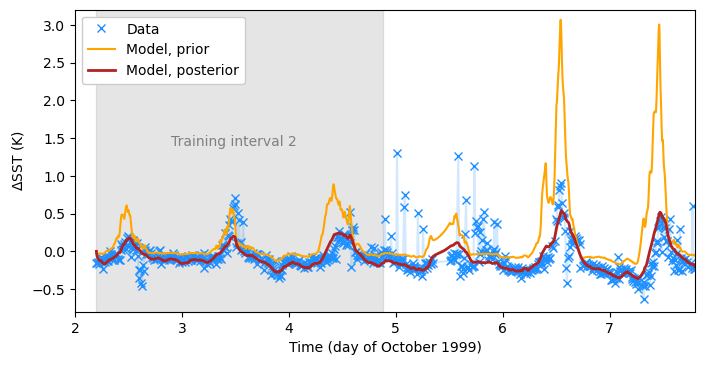

In [75]:
fig, ax = plt.subplots(dpi=100,figsize=(8,4))
ax.plot(times_orig/86400,sst_data,alpha=0.2,c='dodgerblue')
ax.plot(times_orig/86400,sst_data,'x', label='Data',c='dodgerblue')
ax.plot(times3/86400,sst_model3, label='Model, prior',c='orange',lw=1.5)
ax.plot(times2/86400,sst_model2, label='Model, posterior',c='firebrick',lw=2)
ax.legend(framealpha=1)
ax.axvspan(times_orig[0]/86400,times_orig[413-96]/86400,color='gray',alpha=.2)
#ax.set(title='SST-ftemp')
ax.set(xlim=(1,6.8),xticks=np.arange(1,7),xticklabels=np.arange(1,7)+1)
ax.text(1.9,1.4,'Training interval 2',c='gray')
ax.set(xlabel='Time (day of October 1999)')
ax.set(ylabel='$\Delta$SST (K)')
ax.set(ylim=(-.8,3.2))

#plt.savefig('../../Masterarbeit/thesis/figs/res-pacific.pdf',bbox_inches='tight')

plt.show()

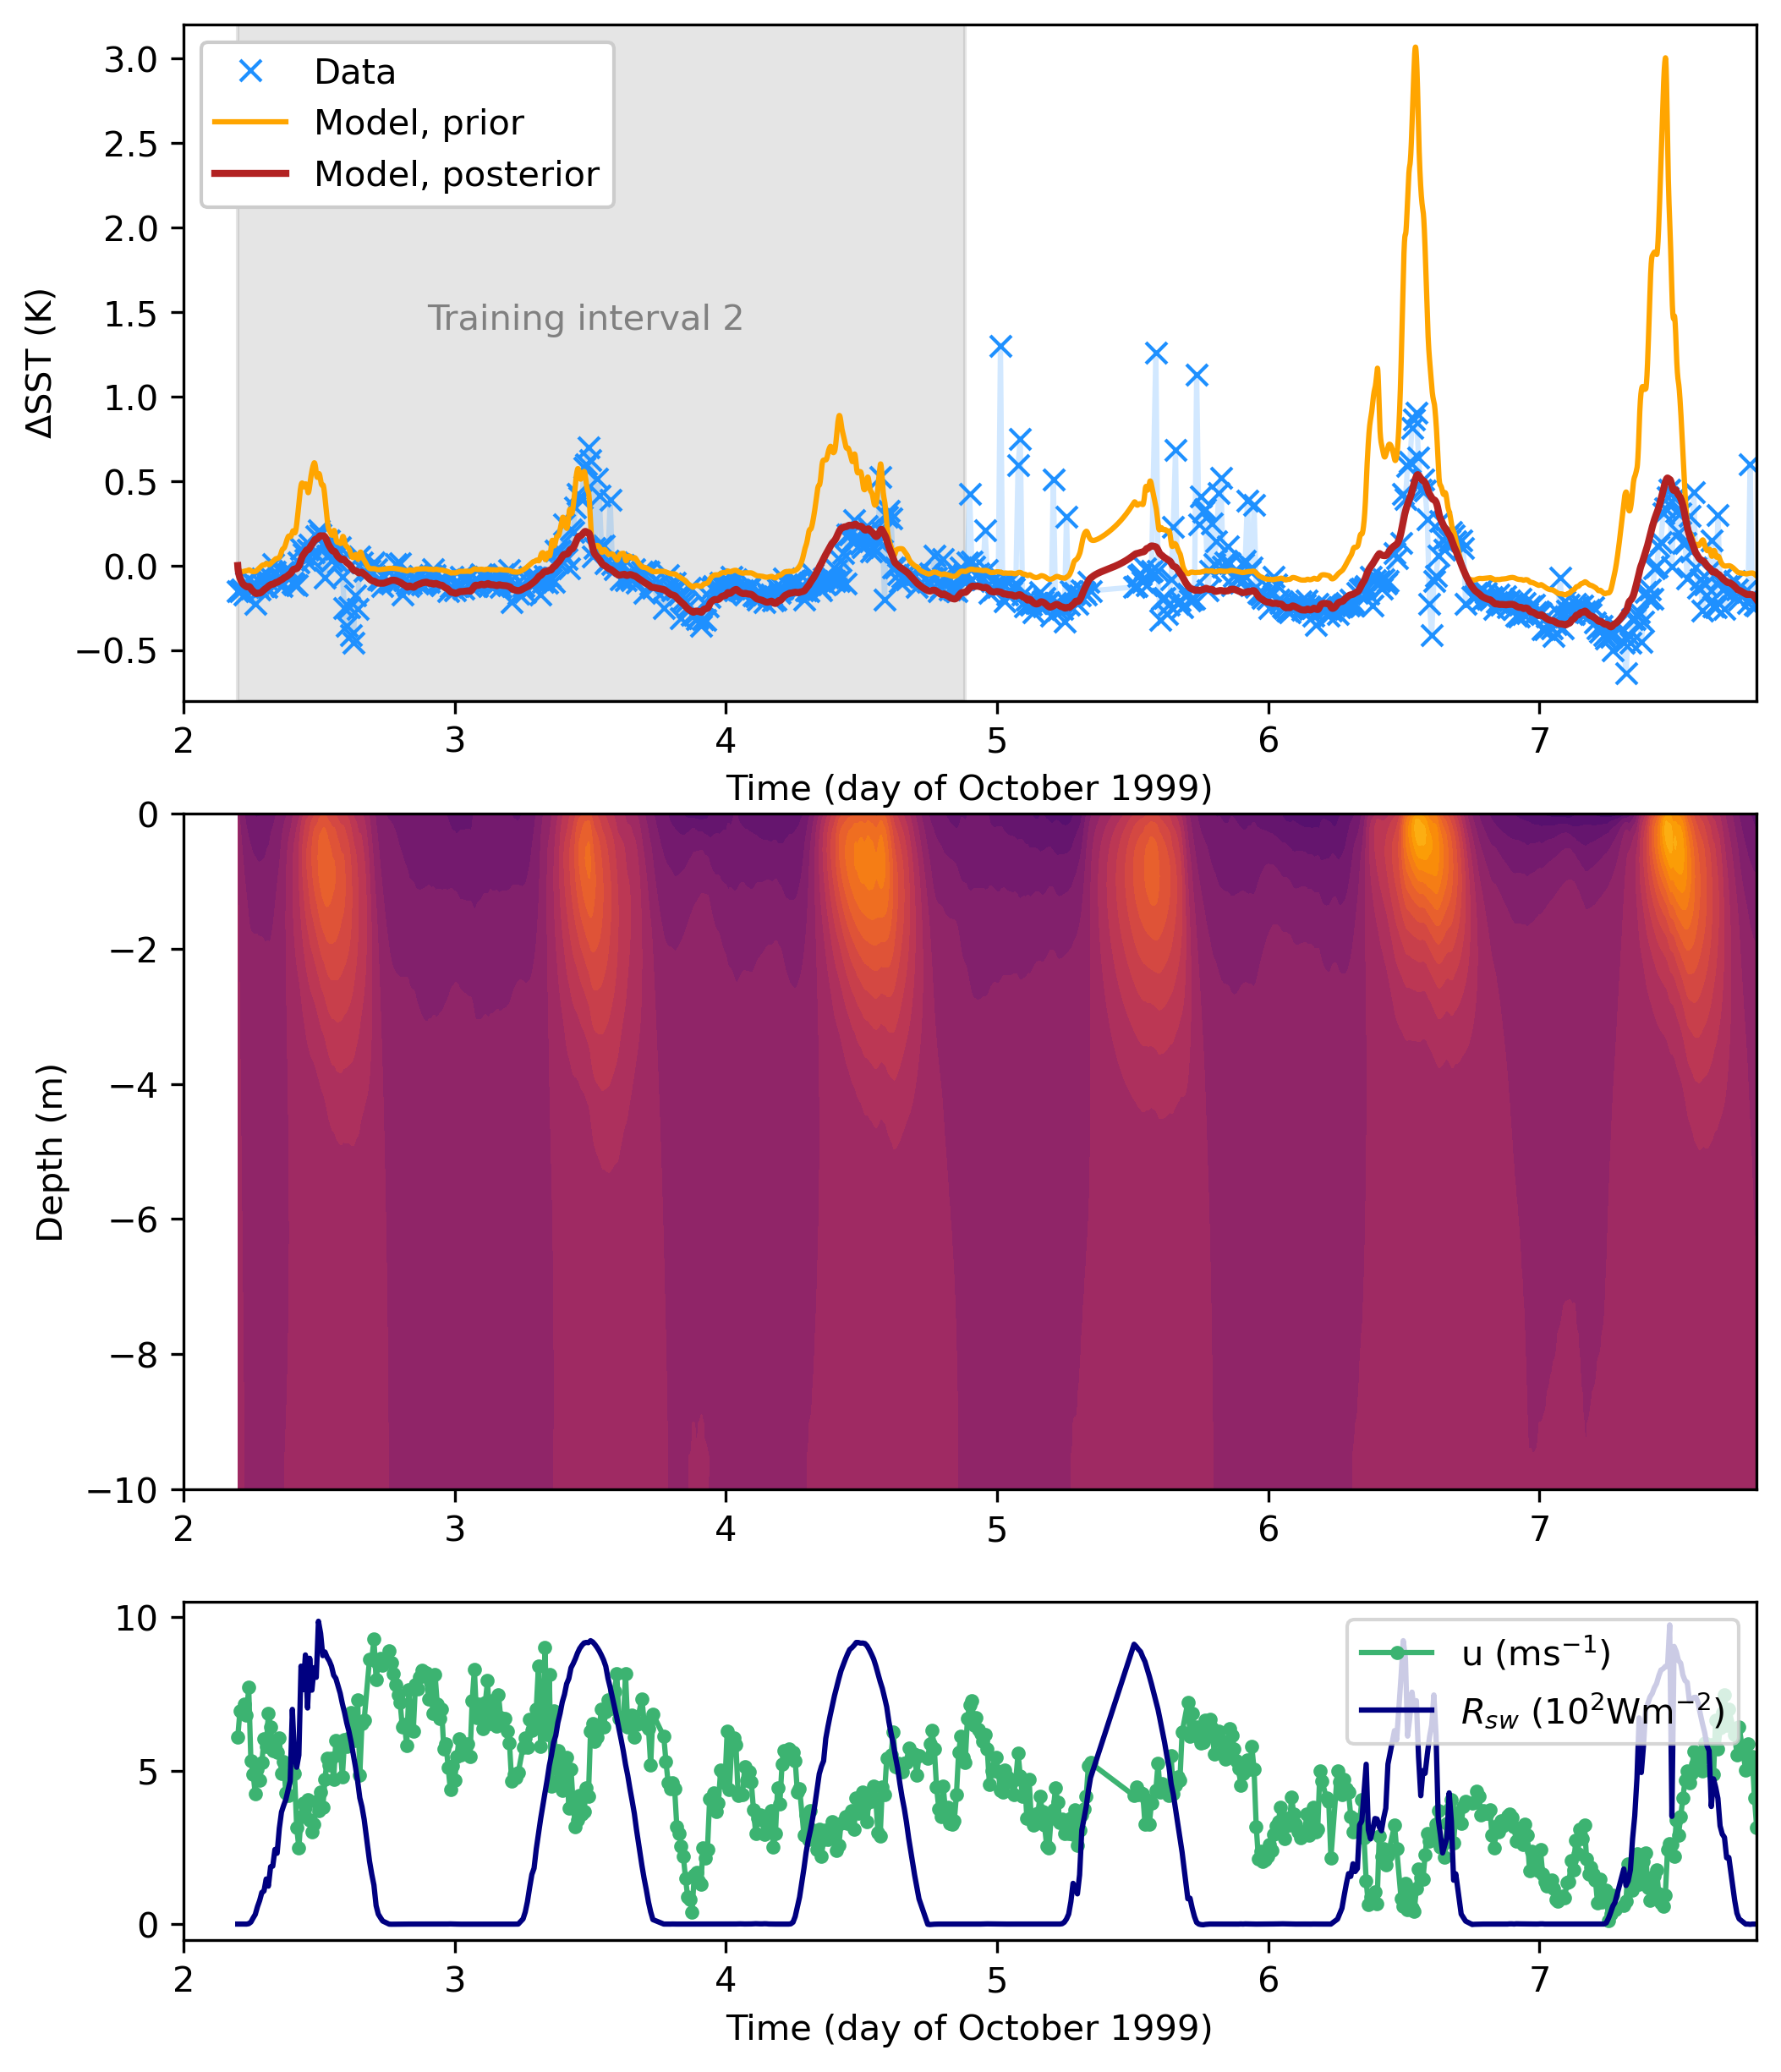

In [79]:
fig, [ax,ax2,ax3] = plt.subplots(3,1,dpi=300,figsize=(8,10),gridspec_kw={'height_ratios': [1, 1,0.5]})
ax.plot(times_orig/86400,sst_data,alpha=0.2,c='dodgerblue')
ax.plot(times_orig/86400,sst_data,'x', label='Data',c='dodgerblue')
ax.plot(times3/86400,sst_model3, label='Model, prior',c='orange',lw=1.5)
ax.plot(times2/86400,sst_model2, label='Model, posterior',c='firebrick',lw=2)
ax.legend(framealpha=1)
ax.axvspan(times_orig[0]/86400,times_orig[413-96]/86400,color='gray',alpha=.2)
#ax.set(title='SST-ftemp')

ax.set(xlim=(1,6.8),xticks=np.arange(1,7),xticklabels=np.arange(1,7)+1)
ax2.set(xlim=(1,6.8),xticks=np.arange(1,7),xticklabels=np.arange(1,7)+1)
ax3.set(xlim=(1,6.8),xticks=np.arange(1,7),xticklabels=np.arange(1,7)+1)
ax.text(1.9,1.4,'Training interval 2',c='gray')
ax.set(xlabel='Time (day of October 1999)')
ax3.set(xlabel='Time (day of October 1999)')
ax.set(ylabel='$\Delta$SST (K)')
ax.set(ylim=(-.8,3.2))

ax2.set(ylim=(-10,0),ylabel='Depth (m)')

ax2.contourf(times2/86400,make_mesh(0.1,40)[0][1:],simu2.transpose()-ftemp1,cmap='inferno',vmin=-0.7,vmax=1.,levels=30)

ax3.plot(times_orig/86400,data_orig['wind'],'.-',c='mediumseagreen',label='u (ms$^{-1}$)')
ax3.plot(times_orig/86400,data_orig['swrad']/100,c='navy',label=r'$R_{sw}$ (10$^2$Wm$^{-2}$)')
ax3.legend()
#ax2.plot(times_orig/86400,data_orig['sst']-ftemp,'.')

#plt.savefig('../../Masterarbeit/thesis/figs/res-pacific-detail2.png',bbox_inches='tight')

plt.show()

## Correlation diagram

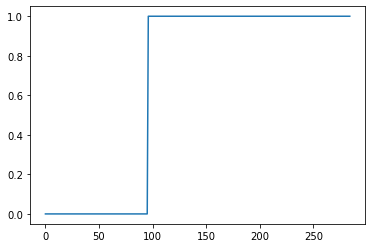

In [10]:
datatype = np.zeros(len(data_orig2)-1)
for i in range(len(datatype)):
    if i >= data_interval1[0] and i < data_interval1[1]:
        datatype[i] = 1
    elif i >= 1290 and i < 1585:
        datatype[i] = 1
plt.plot(datatype)

[[1. 1.]
 [1. 1.]]


NameError: name 'pearson' is not defined

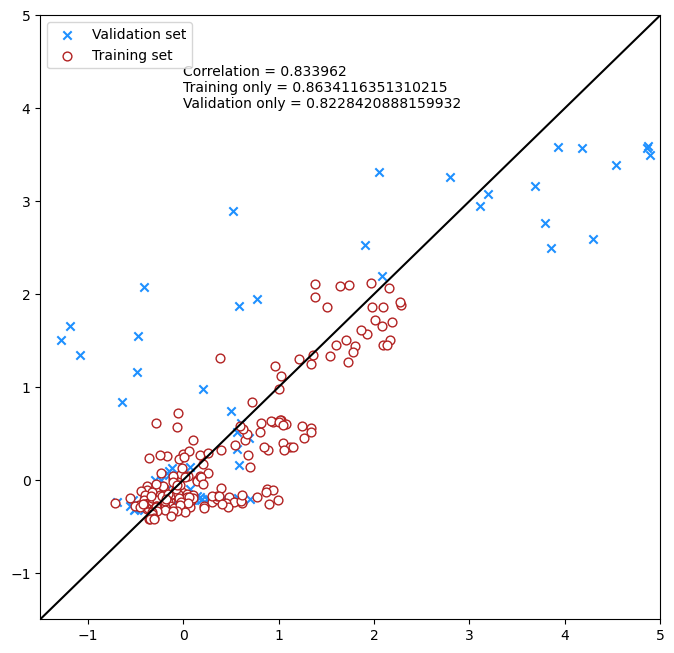

In [11]:
diag = np.linspace(-2,6,200)
corr_training = np.corrcoef(sst_data2[:-1][datatype>0.5],sst_model2[idx2][datatype>0.5])[0][1]
corr_validate = np.corrcoef(sst_data2[:-1][datatype<0.5],sst_model2[idx2][datatype<0.5])[0][1]
corr_total = np.corrcoef(sst_data2[:-1],sst_model2[idx2])[0][1]
print(np.corrcoef(times_orig2[:-1],times2[idx2]))


fig, ax = plt.subplots(dpi=100,figsize=(8,8))
ax.plot(diag,diag,c='k')
ax.scatter(sst_data2[:-1][datatype<0.5],sst_model2[idx2][datatype<0.5],marker='x',c='dodgerblue',label='Validation set')
ax.scatter(sst_data2[:-1][datatype>0.5],sst_model2[idx2][datatype>0.5],facecolors='white',s=40,edgecolors='firebrick',label='Training set')
ax.set(xlim=(-1.5,5),ylim=(-1.5,5))
ax.text(0,4,'Correlation = {:1f}\nTraining only = {}\nValidation only = {}'.format(corr_total,corr_training,corr_validate))
ax.legend()
ax.plot()

print(pearson)